In [52]:
import numpy as np
from scipy import optimize
import os
import subprocess
from contextlib import contextmanager
import time
import matplotlib.pyplot as plt


First, we'll read in the files created by the Fortran HF code. Things are a little messy thanks to the way I stored things in the past, but they are standard numpy arrays after this cell. Take note of the ordering and suggest a more agreeable choice if you've got an opinion.

In [43]:
def read_wfs(restartfile):
    #restartfile = '../HF/wf_numpy.bin'

    intchunk = np.dtype(np.int32).itemsize
    realchunk = np.dtype(np.float64).itemsize
    h = np.fromfile(restartfile, dtype=np.float64, count=1, offset=0)[0]
    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+2*intchunk))[0]
#     print("hbox = ", h)
#     print("nbox = ",nbox)
#     print("lmax = ",lmax)
#     print("nmax = ",nmax)

    #sortstates, sortenergies, wfr,
    sortstates = np.fromfile(restartfile, dtype=np.int32, count=nmax*3*2, offset=(realchunk+3*intchunk)).reshape(2,3,nmax)
    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(realchunk+3*intchunk+nmax*3*2*intchunk)).reshape(2,nmax)
    wfs = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(realchunk+3*intchunk+nmax*3*2*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return h,nbox,lmax,nmax,sortstates,sortenergies,wfs

def print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wfs):
    with open(restartfile, 'wb') as file:
        file.write(h)
        file.write(nbox)
        file.write(lmax)
        file.write(nmax)
        file.write(sortstates.reshape((nmax*3*2,)))
        file.write(sortenergies.reshape((nmax*2,)))
        file.write(wfs.reshape((2*2*(lmax+1)*lmax*(nbox+1),)))

    return

def read_hpsi(restartfile):

    intchunk = np.dtype(np.int32).itemsize

    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(2*intchunk))[0]

    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(3*intchunk)).reshape(2,nmax)
    hpsi = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(3*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return sortenergies,hpsi

def get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    restartfile = '../HF/wf_numpy.bin'
    print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wf)
    make_input(params,1)
    #with cwd('../HF/'):
    oldpwd=os.getcwd()
    os.chdir('../HF/')
    errors.append(run_HF("None",1))
    os.chdir(oldpwd)
    restartfile = '../HF/hpsi.bin'
    sortenergies,hpsi = read_hpsi(restartfile)

    return hpsi

In [44]:
@contextmanager
def cwd(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def spin(spin):
    if(spin==1): return -0.5
    return 0.5

def make_input(params,restart):
    in_template = "../HF/in.template"
    f1 = open(in_template, 'r')
    
    int_string = "&interaction t0= "+str(params[0])+",x0=0.77600,t1=484.2300,x1=-0.31700,t2=-556.6900,x2=-1.0,t3=13757.0,x3=1.2630,w0=125.0,sig=6.0,icoul=1,icm=1,j2terms=.true. / \n"
    if(restart):
        io_string = "&io printwf=F,printdens=F,restartwf=T,printhpsi=T /"
    else:
        io_string = "&io printwf=T,printdens=F,restartwf=F,printhpsi=F /"
    in_out = "../HF/in"
    f2 = open(in_out, 'w')
    f1.seek(0)
    f2.write(f1.read())
    f2.write(int_string)
    f2.write(io_string)
    f2.write("\n")

    f1.close()
    f2.close()

    return

def run_HF(tag,restart):
    noNaN = 1
    if(restart == 0):
        os.system("cp in results/in."+tag)
        #print(os.system("../HF/./main"))
        output = subprocess.run(["./main"], capture_output=True)
        #print(output)
        #print(subprocess.run("../HF/./main",shell=True))
        os.system("mv out results/out."+tag)
        os.system("mv wf_numpy.bin results/wf_numpy.bin."+tag)
        noNaN = os.system("grep -q NaN results/out."+tag)
    else:
        output = subprocess.run(["./main"], capture_output=True)
        #os.system("mv out results/out_rst."+tag)
        #os.system("mv hpsi.bin results/hpsi.bin."+tag)
        #print(output)
        #noNaN = os.system("grep -q NaN results/out_rst."+tag)
    if (noNaN == 0):
        print("NaNs in run {tag}!".format(tag=tag))
        return 1

    return 0


The following cell defines a list of parameters (only one right now) and then loops over those parameters and runs the HF code to generate outputs and WFs.

The inputs, outputs, and WFs are copied to a results folder (this can be changed) with some tag appended to the file name. In the future we may want to change how this tag is generated.

In [45]:
params = [[-2483.45],[-2485.45],[-2453.45],[-2583.45],[-2383.45],]

errors = []

for i in range(len(params)):
    make_input(params[i],0)
    with cwd('../HF/'):
        errors.append(run_HF(str(i),0))




Now we read the files back in and print the energies of the single particle states to see whats up.

In [46]:
params = [[-2483.45],[-2485.45],[-2453.45],[-2583.45],[-1983.45],]

train_wfs = []
states = []
energies = []
levels = [0,0]
for i in range(len(params)):
    if(errors[i] == 1): continue
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs(restartfile)
    train_wfs.append(wf)
    states.append(sortstates)
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    #Calculate energies as a test for levels
    energy = [[],[]]
    for isospin in range(2):
        occupied = 0
        for i in range(lmax):
            level = i
            i_s = sortstates[isospin,2,level]-1
            i_l = sortstates[isospin,1,level]
            i_n = sortstates[isospin,0,level]-1
            if(i_s < 0): continue
            occupied += 1
            sp_en = np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])
            energy[isospin].append(sp_en)
            #print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
            #print("Energy: {}".format(energy[isospin][i]))
        levels[isospin] = occupied
    energies.append(energy)

#h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs()
# npart = 0
# for i in range(nmax):
#     if(sortstates[0,0,i]>0):
#         nfill = int(2*(sortstates[0,1,i]+spin(sortstates[0,2,i])) + 1)
#         if (sortstates[0,1,i] == 0): nfill = 2
#         npart += nfill
#         print(npart)

Now we can calculate the hpsi (or, G) objects from Wfs. Here I am reading in training Wfs just as a test.

In [9]:
for i in range(len(params)-4):
    if(errors[i] == 1): continue
    # The following is to simply read in the trial WFs during testing
    restartfile = '../HF/results/wf_numpy.bin.'+str(i)
    h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs(restartfile)

    # get hpsi
    hpsi = get_hpsi(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    #Calculate energies as a test for levels
    occupied = 0
    for i in range(nmax):
        isospin = 0
        level = i
        i_s = sortstates[isospin,2,level]-1
        i_l = sortstates[isospin,1,level]
        i_n = sortstates[isospin,0,level]-1
        if(i_s < 0): continue
        occupied += 1
        print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
        print("Energy: {}".format(np.sum(-h*wf[isospin,i_s,i_l,i_n,:]*hpsi[isospin,i_s,i_l,i_n,:])))

print("There are {} occupied levels!".format(occupied))

Level: 1, N: 1, L: 0, S: 0
Energy: -49.71129278586775
Level: 2, N: 1, L: 1, S: 1
Energy: -35.89095593307716
Level: 3, N: 1, L: 1, S: 0
Energy: -33.846486193249426
Level: 4, N: 1, L: 2, S: 1
Energy: -22.12394236411225
Level: 5, N: 2, L: 0, S: 0
Energy: -17.757508449901596
Level: 6, N: 1, L: 2, S: 0
Energy: -17.429233705493058
Level: 7, N: 1, L: 3, S: 1
Energy: -9.231279254081628
There are 7 occupied levels!


$ \braket{\psi_k\vert G(\phi)} - \lambda \braket{\psi_k\vert\phi} = 0$ 

$ \braket{\phi\vert\phi} - 1 = 0 $

In [47]:
def make_wf(coeffs,train_wfs,states,levels):
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    trial_wf = np.zeros(train_wfs[0].shape)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = sortstates[isospin,2,j]-1
                i_l = sortstates[isospin,1,j]
                i_n = sortstates[isospin,0,j]-1
                trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
                    + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]
    return trial_wf

def galerkin(coeffs,train_wfs,states,levels,params):
    
    global count
    global prev_time
    
    count += 1
    print("Iteration {}".format(count))
    print("Iteration time: {}".format(time.time() - prev_time))
    
    prev_time = time.time()
    
    results = np.zeros(coeffs.shape)
    
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    
    trial_wf = make_wf(coeffs,train_wfs,states,levels)

    hpsi = get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)

    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = sortstates[isospin,2,j]-1
                i_l = sortstates[isospin,1,j]
                i_n = sortstates[isospin,0,j]-1
                ele = i*tot_levels + isospin*levels[0] + j
                lam = coeffs[train_num*tot_levels + isospin*levels[0] + j]
                results[ele] = h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],hpsi[isospin,i_s,i_l,i_n,:]) \
                    - lam*h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])


    for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            ele = train_num*tot_levels + isospin*levels[0] + j
            results[ele] = h*np.dot(trial_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:]) - 1.0
            
    return results



In [49]:
global count
count = 0

start_time = time.time()
global prev_time 
prev_time = time.time()

train_num = len(train_wfs)

print("Training with {} WFs, each one with {} total states".format(train_num,sum(levels)))

ak = np.zeros((train_num,sum(levels)))
lam = np.zeros((sum(levels)))
coeffs = np.zeros((train_num*sum(levels) + sum(levels)))
coeffs[0:train_num*sum(levels)] = 0.1
coeffs[train_num*sum(levels):-1] = 25.0
#coeffs = sol.x

test_params = [-2493.45,]
#galerkin(coeffs,wfs,states,levels,test_params)

hybr_dict = {'col_deriv': 0, 'xtol': 1.49012e-8, 'maxfev': 200, 'band': None, 'eps': None, 'factor': 10, 'diag': None}
sol = optimize.root(galerkin, coeffs, args=(train_wfs,states,levels,test_params), method='hybr', options=hybr_dict)
print(sol.x)
print(galerkin(sol.x,train_wfs,states,levels,test_params))
print("Total time took: {}".format(time.time()-start_time))

Training with 5 WFs, each one with 13 total states
Iteration 1
Iteration time: 0.0012061595916748047
Iteration 2
Iteration time: 0.17866110801696777
Iteration 3
Iteration time: 0.19608807563781738
Iteration 4
Iteration time: 0.1553480625152588
Iteration 5
Iteration time: 0.17406058311462402
Iteration 6
Iteration time: 0.17602205276489258
Iteration 7
Iteration time: 0.1643517017364502
Iteration 8
Iteration time: 0.15685009956359863
Iteration 9
Iteration time: 0.17229962348937988
Iteration 10
Iteration time: 0.17002320289611816
Iteration 11
Iteration time: 0.16734051704406738
Iteration 12
Iteration time: 0.17760610580444336
Iteration 13
Iteration time: 0.19867730140686035
Iteration 14
Iteration time: 0.17707419395446777
Iteration 15
Iteration time: 0.1671295166015625
Iteration 16
Iteration time: 0.1697828769683838
Iteration 17
Iteration time: 0.18328189849853516
Iteration 18
Iteration time: 0.18288898468017578
Iteration 19
Iteration time: 0.18444418907165527
Iteration 20
Iteration time: 

In [16]:
# Make the test WF with test_params
make_input(test_params,0)
with cwd('../HF/'):
    errors.append(run_HF("test",0))


In [50]:
# Make trial WF and hpsi with solved coeffs
trial_wf = make_wf(sol.x,train_wfs,states,levels)
trial_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sorts,sorte,trial_wf)

# Read in the cheated test
restartfile = '../HF/results/wf_numpy.bin.test'
h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
test_hpsi = get_hpsi(test_params,h,nbox,lmax,nmax,sorts,sorte,test_wf)

for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[isospin,2,j]-1
            i_l = sortstates[isospin,1,j]
            i_n = sortstates[isospin,0,j]-1
            norm = np.dot(h*test_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            trial_sp = np.dot(-h*trial_hpsi[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])
            test_sp = np.dot(-h*test_hpsi[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            print("Trial: {trial} Test: {test} Difference: {diff} Norm: {norm}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=norm))



Trial: -51.041531198229166 Test: -50.79402092150503 Difference: 0.004849193801864674 Norm: 0.9999615652853093
Trial: -36.89835231663524 Test: -36.78390856064573 Difference: 0.003101595296381747 Norm: 0.999924527193359
Trial: -34.762218753753054 Test: -34.73027598352694 Difference: 0.0009188933092099573 Norm: 0.9999243944714074
Trial: -22.826951206752195 Test: -22.808868913974003 Difference: 0.0007921466434310238 Norm: 0.9999145839523229
Trial: -17.933453530940977 Test: -18.083046244545542 Difference: -0.008341545221419304 Norm: 0.9998910940704654
Trial: -18.302079932156623 Test: -18.377310249990394 Difference: -0.0041104791429520575 Norm: 0.9997923269631708
Trial: -9.667422709131593 Test: -9.713781708914386 Difference: -0.004795383545089389 Norm: 0.9998722309380264
Trial: -47.30067475933152 Test: -47.105000036720696 Difference: 0.004136827299112091 Norm: 1.0001333031063808
Trial: -35.38252318928082 Test: -35.294948341687 Difference: 0.0024750876901947984 Norm: 0.999929158688806
Trial: 

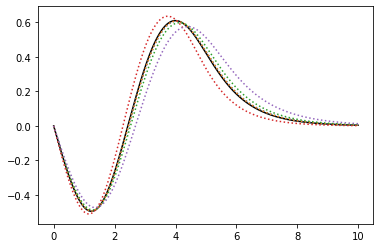

In [86]:
fig = plt.figure()
ax = plt.axes()

isospin = 0
i_s = 0
i_l = 0
i_n = 1

x = np.linspace(0, 20, 2001)
ax.plot(x[:1000],trial_wf[isospin,i_s,i_l,i_n,:1000],color='black')
for i in range(len(train_wfs)):
    ax.plot(x[:1000],train_wfs[i][isospin,i_s,i_l,i_n,:1000],linestyle=":")
#ax.plot(trial_wf[isospin,i_s,i_l,i_n,:],linestyle='--')